# Maximisation de la rentabilité d'une installation de stockage

## Importer les données annuelles de la PPE

In [1]:
!pip install nb_black

     |████████████████████████████████| 1.1 MB 3.3 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for nb-black: filename=nb_black-1.0.7-py3-none-any.whl size=5280 sha256=dd11abebb959f7c82c45fa1fc341ac623fe619c1f0bd3c747d56b77479ff1b44
  Stored in directory: /Users/MacBookBenjamin/Library/Caches/pip/wheels/1e/b2/88/51c66d23ea5fd0d40ed50997555e15d981d92671376a9a412a
  Created wheel for black: filename=black-20.8b1-py3-none-any.whl size=124184 sha256=ccbb401f0308086f79ac2329a841fbdbecabb463c7d84773f80ba2adffa9e593
  Stored in directory: /Users/MacBookBenjamin/Library/Caches/pip/wheels/c5/85/79/f3af8daaf8037c0bf14beb3b7a1511a39b6e6902ca2aaf494e
Successfully built nb-black black


In [2]:
%load_ext lab_black

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data = pd.read_excel("historic_data.xlsx")
data = data.drop(["Unnamed: 8", "moyen à considérer comme"], axis=1).set_index("Date")

In [3]:
data.head()

,Consommation (MW),Thermique (MW),Bagasse/charbon (MW),Hydraulique (MW),Photovoltaïque (MW),Eolien (MW),Bioénergies (MW)
Date,,,,,,,
2017-01-01 04:00:00,258.452,29.471,198.937,29.183,-0.434,-0.059,1.353
2017-01-01 05:00:00,251.673,30.472,194.092,26.283,-0.427,-0.060,1.313
2017-01-01 06:00:00,242.021,30.010,181.286,29.805,-0.359,-0.062,1.341
2017-01-01 07:00:00,233.028,24.341,173.220,22.226,11.997,-0.042,1.285
2017-01-01 08:00:00,245.900,14.836,163.957,19.252,46.460,0.030,1.365


In [5]:
data["Fatal (MW)"] = (
    data["Photovoltaïque (MW)"]
    + data["Eolien (MW)"]
    + data["Bioénergies (MW)"]
    + data["Hydraulique (MW)"]
)

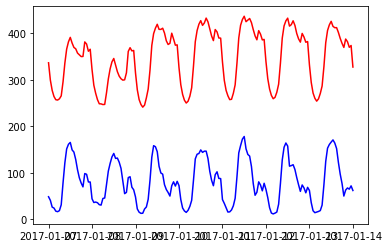

In [9]:
week = data.loc['2017-01-07 00:00':'2017-01-14 00:00']
demand = week['Consommation (MW)']
plt.plot(demand, 'r')
prod_fatale = week['Fatal (MW)']
plt.plot(prod_fatale, 'b')

costs = np.array([20, 40])
power_max = np.array([400, 200])
power_min = np.array([50, 20])

## La modélisation du problème de rentabilité

On va d'abord définir une colonne FATAL représentant les énergies non dispatchables, incluant l'yhdraulique qui pour le moment sera considéré comme 100% fatal.

In [6]:
data["Fatal (MW)"] = (
    data["Photovoltaïque (MW)"]
    + data["Eolien (MW)"]
    + data["Bioénergies (MW)"]
    + data["Hydraulique (MW)"]
)

In [7]:
df = data.copy()
df.columns = [
    "Consommation",
    "Thermique",
    "Bagasse",
    "Hydraulique",
    "PV",
    "Eolien",
    "Bioenergies",
    "FATAL",
]
df = df.drop(["Hydraulique", "PV", "Eolien", "Bioenergies"], axis=1)

On va alors optimiser la répartition de la production entre thermique, bagasse/charbon et stockage sur des durée d'une semaine. Pour cela nous aurons besoin des capacités de stockage - on considère dans un premier temps qu'il n'y pas de contrainte sur la puissance de charge et décharge du stockage autre qu'une majoration de puissance max, nous expliquerons pourquoi plus loin. Nous aurons aussi besoin des capacités de production du thermique et de la bagasse/charbon, ainsi que leurs contraintes de temps d'arrêt et le coût de production associé.

In [13]:
pmin_ther, pmax_ther = 10, 300
pmin_char, pmax_char = 150, 1100
capa_stock = 550
pmax_stock = 100
cost_ther = 300
cost_char = 150

Cette optimisation par semaine sur l'année nous retournera le coût de production annuel.

Dans un deuxième temps nous aurons besoin d'une évaluation du coût fixe annuel de cette capacité de stockage supplémentaire installée, pour faire un rapport entre le coût évité par une nouvelle installation et ce coût fixe annuel. Il devra prendre en compte notamment le CAPEX répartit sur une durée de vie estimée et l'OPEX associée. 
Nous ne prenons pas en compte l'utilisation du stockage dans l'année sur cette évaluation du coût fixe, alors que cette utilisation peut avoir une grande importance sur la durée de vie (par exemple pour une batterie mal utilisée), mais construire ce modèle serait trop complexe ici.

## Rentabilité d'une installation de stockage

In [10]:
import pulp
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# Récupération d'une semaine
week = df.loc['2017-01-01':'2017-01-07']
week

,Consommation,Thermique,Bagasse,FATAL
Date,,,,
2017-01-01 04:00:00,258.452,29.471,198.937,30.043
2017-01-01 05:00:00,251.673,30.472,194.092,27.109
2017-01-01 06:00:00,242.021,30.010,181.286,30.725
2017-01-01 07:00:00,233.028,24.341,173.220,35.466
2017-01-01 08:00:00,245.900,14.836,163.957,67.107
...,...,...,...,...
2017-01-07 19:00:00,350.045,92.799,186.517,69.846
2017-01-07 20:00:00,381.292,95.241,186.704,98.462
2017-01-07 21:00:00,376.769,92.802,186.232,96.850


In [8]:
def solve_week(week):
    df = week.copy()
    tprob = pulp.LpProblem("Week", pulp.LpMinimize)
    demand = list(week["Consommation"])
    fatal = list(week["FATAL"])
    nbsteps = week.shape[0]
    ## production
    p_ther = [pulp.LpVariable(f"p_ther_{t}", 0, pmax_ther) for t in range(0, nbsteps)]
    p_char = [pulp.LpVariable(f"p_char_{t}", 0, pmax_char) for t in range(0, nbsteps)]
    p_load = [pulp.LpVariable(f"p_load_{t}", 0, pmax_stock) for t in range(0, nbsteps)]
    stock = [pulp.LpVariable(f"stock_{t}", 0, capa_stock) for t in range(0, nbsteps)]

    ## on/off
    on_ther = [
        pulp.LpVariable(f"on_ther_{t}", cat=pulp.LpBinary) for t in range(0, nbsteps)
    ]
    on_char = [
        pulp.LpVariable(f"on_char_{t}", cat=pulp.LpBinary) for t in range(0, nbsteps)
    ]
    on_load = [
        pulp.LpVariable(f"on_load_{t}", cat=pulp.LpBinary) for t in range(0, nbsteps)
    ]

    # constraints
    for t in range(0, nbsteps):
        tprob += p_ther[t] >= pmin_ther * on_ther[t]  # if 'on' produce at least min
        tprob += (
            p_ther[t] <= pmax_ther * on_ther[t]
        )  # if 'on' produce at most max, if 'off' produce 0
        tprob += p_char[t] >= pmin_char * on_char[t]
        tprob += p_char[t] <= pmax_char * on_char[t]
        tprob += p_load[t] >= 0 * on_load[t]
        tprob += p_load[t] <= pmax_stock * on_load[t]

        tprob += p_load[t] <= stock[t - 1]
        tprob += p_ther[t] + p_char[t] + fatal[t] + p_load[t] >= demand[t]

    for t in range(1, nbsteps):
        tprob += stock[t] == stock[t - 1] - p_load[t - 1] + (
            p_load[t - 1] + p_ther[t - 1] + p_char[t - 1] + fatal[t - 1] - demand[t - 1]
        )

    # Add constraints on stopping time

    # objective
    tprob += sum(
        [p_ther[t] * cost_ther + p_char[t] * cost_char for t in range(0, nbsteps)]
    )
    tprob.solve()
    df["Pred_thermique"] = [pulp.value(p_ther[t]) for t in range(0, nbsteps)]
    df["Pred_charbon"] = [pulp.value(p_char[t]) for t in range(0, nbsteps)]
    df["Puissance_stock"] = [pulp.value(p_load[t]) for t in range(0, nbsteps)]
    df["Stockage"] = [pulp.value(stock[t]) for t in range(0, nbsteps)]
    
    #df.assign(Pred_thermique=[pulp.value(p_ther[t]) for t in range(0, nbsteps)], 
    #         Pred_charbon= lambda df: df.solaire - df.pv)
    return df

In [29]:
result = solve_week(week)

In [32]:
def plot_week(week):
    week.plot(y=['Consommation', 'Pred_thermique', 'Pred_charbon', 'Puissance_stock', 'FATAL'])

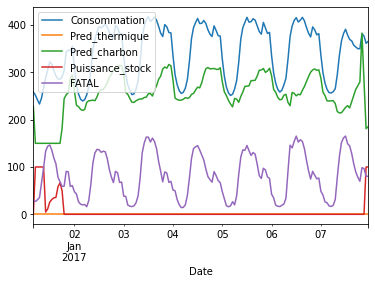

In [33]:
plot_week(result)

## Optimisation de l'installation de stockage

À partir de cette fonction qui modélise la rentabilité d'une installation de stockage selon la capacité installée, nous cherchons à trouver l'installation (en terme de capacité) qui maximise la rentabilité.
Puisque chaque appel à notre fonction demande beaucoup de ressource (en temps de calcul), nous voulons réaliser cette optimisation en limitant le nombre d'appel à la fonction. De plus, cette fonction est considérée comme une boîte noire, nous ne pouvons en tirer de gradient.
Note : la fonction ici ne coûte en réalité pas excessivement cher, mais puisque plus tard cette évaluation de la rentabilité prendre compte de l'évolution du parc de production, du mode d'utilisation du stockage sur le coût opérationnel, la fonction sera en réalité effectivement gourmande en énergie.